# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [3]:
import psycopg2
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
conn = psycopg2.connect(database='mid_term_project',user='lhl_student',password='lhl_student', host='mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com', port='5432')

print('Connection opened successfully')

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Connection opened successfully


In [4]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Our goal is to predict delays of flights.
## Table **flights**

Features **X**:

- **fl_date**: Flight Date (yyyy-mm-dd)
- **mkt_carrier**: Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique. For analysis, use the Unique Carrier Code.
- **mkt_carrier_fl_num**: Flight Number
- **tail_num**: Tail Number
- **op_carrier_fl_num**: Flight Number
- **origin**: Origin Airport
- **origin_city_name**: Origin Airport, City Name
- **dest**: Destination Airport
- **dest_city_name**: Destination Airport, City Name
- **crs_dep_time**: CRS Departure Time (local time: hhmm)
- **crs_arr_time**: CRS Arrival Time (local time: hhmm)
- **dup**: Duplicate flag marked Y if the flight is swapped based on Form-3A data
- **crs_elapsed_time**: CRS Elapsed Time of Flight, in Minutes
- **flights**: Number of Flights
- **distance**: Distance between airports (miles)

Variable **Y**:
- **arr_delay**: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.





In [ ]:
column_names = ['fl_date','mkt_carrier', 'mkt_carrier_fl_num','tail_num','op_carrier_fl_num','origin','origin_city_name','dest','dest_city_name','crs_dep_time','crs_arr_time','dup','crs_elapsed_time','flights','distance']
df_flights = postgresql_to_dataframe(conn, 'SELECT fl_date, mkt_carrier, mkt_carrier_fl_num, tail_num, op_carrier_fl_num, origin, origin_city_name, dest, dest_city_name, crs_dep_time, crs_arr_time, dup, crs_elapsed_time, flights, distance from flights where cancelled = 0 and diverted = 0 limit 1000000;', column_names)
df_flights.isnull().sum()

In [ ]:
column_names = ['fl_date','mkt_unique_carrier','op_unique_carrier','mkt_carrier_fl_num','tail_num','origin','origin_city_name','dest','dest_city_name','crs_dep_time','crs_arr_time','crs_elapsed_time','distance','arr_delay']
df_flights = postgresql_to_dataframe(conn, 'SELECT fl_date,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay FROM flights WHERE cancelled = 0 and diverted = 0 LIMIT 1000000', column_names)

In [ ]:
column_names = ['mkt_carrier', 'mkt_carrier_fl_num','mkt_unique_carrier','op_unique_carrier','op_carrier_fl_num','flights']
carriers = postgresql_to_dataframe(conn, 'SELECT mkt_carrier,mkt_carrier_fl_num, mkt_unique_carrier, op_unique_carrier, op_carrier_fl_num, flights from flights where cancelled = 0 and diverted = 0 LIMIT 1000000 ;', column_names)
carriers

In [ ]:
carriers['mkt_unique_carrier'].value_counts()

In [ ]:
carriers['mkt_carrier'].value_counts()

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [ ]:
column_names = ['dup','count_dup']
postgresql_to_dataframe(conn,'select dup, count(dup) from flights group by dup',column_names)


,dup,count_dup
0,N,15927485


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df_flights = pd.read_csv('drive/MyDrive/training_data.csv')

In [ ]:
df_flights.head()

,fl_date,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay
0,2019-06-03,WN,WN,510,N8639B,BDL,"Hartford, CT",DEN,"Denver, CO",1640,1905,265.0,1671.0,36.0
1,2019-07-25,AA,AA,12,N923NN,DFW,"Dallas/Fort Worth, TX",JAX,"Jacksonville, FL",1509,1830,141.0,918.0,32.0
2,2019-08-11,WN,WN,4462,N8552Z,MDW,"Chicago, IL",PVD,"Providence, RI",2215,125,130.0,842.0,-17.0
3,2018-01-29,AA,MQ,3652,N508AE,ORD,"Chicago, IL",RAP,"Rapid City, SD",1007,1135,148.0,779.0,5.0
4,2018-02-18,AS,AS,9,N462AS,MCO,"Orlando, FL",SEA,"Seattle, WA",700,1040,400.0,2554.0,-22.0


In [ ]:
import datetime as dt
df_flights['year'] = pd.DatetimeIndex(df_flights['fl_date']).year
df_flights['month'] = pd.DatetimeIndex(df_flights['fl_date']).month
df_flights['day'] = pd.DatetimeIndex(df_flights['fl_date']).day
df_flights['week'] = pd.to_datetime(df_flights['fl_date']).dt.isocalendar().week
df_flights['crs_dep_hour'] = (df_flights['crs_dep_time'] // 100)
df_flights['crs_arr_hour'] = (df_flights['crs_arr_time'] // 100)

df_flights.head()

,fl_date,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,year,month,day,week,crs_dep_hour,crs_arr_hour
0,2019-06-03,WN,WN,510,N8639B,BDL,"Hartford, CT",DEN,"Denver, CO",1640,1905,265.0,1671.0,36.0,2019,6,3,23,16,19
1,2019-07-25,AA,AA,12,N923NN,DFW,"Dallas/Fort Worth, TX",JAX,"Jacksonville, FL",1509,1830,141.0,918.0,32.0,2019,7,25,30,15,18
2,2019-08-11,WN,WN,4462,N8552Z,MDW,"Chicago, IL",PVD,"Providence, RI",2215,125,130.0,842.0,-17.0,2019,8,11,32,22,1
3,2018-01-29,AA,MQ,3652,N508AE,ORD,"Chicago, IL",RAP,"Rapid City, SD",1007,1135,148.0,779.0,5.0,2018,1,29,5,10,11
4,2018-02-18,AS,AS,9,N462AS,MCO,"Orlando, FL",SEA,"Seattle, WA",700,1040,400.0,2554.0,-22.0,2018,2,18,7,7,10


In [ ]:
#df_flights = pd.concat([df_flights, pd.get_dummies(df_flights['dup'], prefix = 'dup')], axis = 1)
#df_flights['dup'].value_counts()
df_flights.shape

(5000000, 20)

Define haul lengths

In [ ]:
#short = 0, medium = 1, long = 2
df_flights['flight_length'] = np.select (
    [ 
     (df_flights['distance'] < 800),
     (df_flights['distance'].between(800, 2200, inclusive=False)),
     (df_flights['distance'] >=2200)
    ], 
    [
     'short',
     'medium',
     'long'
    ]
                                    )
df_flights = pd.concat([df_flights,pd.get_dummies(df_flights['flight_length'], prefix = 'flight_haul')], axis = 1)
print(df_flights.shape)
df_flights.head()

(5000000, 24)


,fl_date,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,year,month,day,week,crs_dep_hour,crs_arr_hour,flight_length,flight_haul_long,flight_haul_medium,flight_haul_short
0,2019-06-03,WN,WN,510,N8639B,BDL,"Hartford, CT",DEN,"Denver, CO",1640,1905,265.0,1671.0,36.0,2019,6,3,23,16,19,medium,0,1,0
1,2019-07-25,AA,AA,12,N923NN,DFW,"Dallas/Fort Worth, TX",JAX,"Jacksonville, FL",1509,1830,141.0,918.0,32.0,2019,7,25,30,15,18,medium,0,1,0
2,2019-08-11,WN,WN,4462,N8552Z,MDW,"Chicago, IL",PVD,"Providence, RI",2215,125,130.0,842.0,-17.0,2019,8,11,32,22,1,medium,0,1,0
3,2018-01-29,AA,MQ,3652,N508AE,ORD,"Chicago, IL",RAP,"Rapid City, SD",1007,1135,148.0,779.0,5.0,2018,1,29,5,10,11,short,0,0,1
4,2018-02-18,AS,AS,9,N462AS,MCO,"Orlando, FL",SEA,"Seattle, WA",700,1040,400.0,2554.0,-22.0,2018,2,18,7,7,10,long,1,0,0


In [ ]:
df_flights[~(df_flights['mkt_unique_carrier'] == df_flights['op_unique_carrier'])]

,fl_date,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,year,month,day,week,crs_dep_hour,crs_arr_hour,flight_length,flight_haul_long,flight_haul_medium,flight_haul_short
3,2018-01-29,AA,MQ,3652,N508AE,ORD,"Chicago, IL",RAP,"Rapid City, SD",1007,1135,148.0,779.0,5.0,2018,1,29,5,10,11,short,0,0,1
7,2019-05-08,UA,EV,4377,N14105,EWR,"Newark, NJ",JAX,"Jacksonville, FL",1545,1822,157.0,820.0,8.0,2019,5,8,19,15,18,medium,0,1,0
8,2019-03-11,DL,OO,4314,N878AS,SWF,"Newburgh/Poughkeepsie, NY",DTW,"Detroit, MI",1747,1939,112.0,479.0,-2.0,2019,3,11,11,17,19,short,0,0,1
9,2019-05-18,UA,AX,4785,N17146,ISN,"Williston, ND",DEN,"Denver, CO",1655,1758,123.0,576.0,3.0,2019,5,18,20,16,17,short,0,0,1
19,2018-07-14,DL,9E,5047,N910XJ,BHM,"Birmingham, AL",ATL,"Atlanta, GA",938,1142,64.0,134.0,-7.0,2018,7,14,28,9,11,short,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999988,2018-09-05,AA,MQ,4219,N661JA,ORD,"Chicago, IL",PIA,"Peoria, IL",2015,2109,54.0,130.0,75.0,2018,9,5,36,20,21,short,0,0,1
4999989,2018-04-02,AA,MQ,3577,N247NN,TLH,"Tallahassee, FL",DFW,"Dallas/Fort Worth, TX",1629,1800,151.0,767.0,-6.0,2018,4,2,14,16,18,short,0,0,1
4999993,2018-10-26,UA,ZW,3766,N438AW,ABE,"Allentown/Bethlehem/Easton, PA",ORD,"Chicago, IL",755,909,134.0,654.0,2.0,2018,10,26,43,7,9,short,0,0,1
4999994,2019-09-01,DL,OO,3983,N910EV,ATL,"Atlanta, GA",TRI,"Bristol/Johnson City/Kingsport, TN",2229,2333,64.0,227.0,-7.0,2019,9,1,35,22,23,short,0,0,1


In [ ]:
df_flights['mkt_unique_carrier'].value_counts()

AA    1287815
DL    1105966
UA     967740
WN     851625
AS     269110
B6     189359
NK     120451
F9      80162
G4      63880
HA      58575
VX       5317
Name: mkt_unique_carrier, dtype: int64

In [ ]:
df_flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'op_unique_carrier',
       'mkt_carrier_fl_num', 'tail_num', 'origin', 'origin_city_name', 'dest',
       'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time',
       'distance', 'arr_delay', 'year', 'month', 'day', 'week', 'crs_dep_hour',
       'crs_arr_hour', 'flight_length', 'flight_haul_long',
       'flight_haul_medium', 'flight_haul_short'],
      dtype='object')

time of the day: the delay probably depends on the airport traffic which varies during the day.

In [ ]:
#morning = 0, noon = 1, evening = 2, night = 3
df_flights['time_of_day'] = np.select (
    [ 
     (df_flights['crs_arr_hour'] .between(4, 11, inclusive=True)),
     (df_flights['crs_arr_hour'].between(12, 17, inclusive=True)),
     (df_flights['crs_arr_hour'].between(18, 23, inclusive=True)),
     (df_flights['crs_arr_hour'].between(0, 3, inclusive=True) | (df_flights['crs_arr_hour'] == 24) ),
    ], 
    [
     'morning',
     'noon',
     'evening',
     'night'
    ]
                                    )
df_flights = pd.concat([df_flights,pd.get_dummies(df_flights['time_of_day'], prefix = 'crs_arr')], axis = 1)
print(df_flights.shape)
df_flights.head()
#df_flights[['time_of_day','crs_arr_hour','flights']].groupby(['time_of_day','crs_arr_hour']).count()

(5000000, 29)


,fl_date,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,year,month,day,week,crs_dep_hour,crs_arr_hour,flight_length,flight_haul_long,flight_haul_medium,flight_haul_short,time_of_day,crs_arr_evening,crs_arr_morning,crs_arr_night,crs_arr_noon
0,2019-06-03,WN,WN,510,N8639B,BDL,"Hartford, CT",DEN,"Denver, CO",1640,1905,265.0,1671.0,36.0,2019,6,3,23,16,19,medium,0,1,0,evening,1,0,0,0
1,2019-07-25,AA,AA,12,N923NN,DFW,"Dallas/Fort Worth, TX",JAX,"Jacksonville, FL",1509,1830,141.0,918.0,32.0,2019,7,25,30,15,18,medium,0,1,0,evening,1,0,0,0
2,2019-08-11,WN,WN,4462,N8552Z,MDW,"Chicago, IL",PVD,"Providence, RI",2215,125,130.0,842.0,-17.0,2019,8,11,32,22,1,medium,0,1,0,night,0,0,1,0
3,2018-01-29,AA,MQ,3652,N508AE,ORD,"Chicago, IL",RAP,"Rapid City, SD",1007,1135,148.0,779.0,5.0,2018,1,29,5,10,11,short,0,0,1,morning,0,1,0,0
4,2018-02-18,AS,AS,9,N462AS,MCO,"Orlando, FL",SEA,"Seattle, WA",700,1040,400.0,2554.0,-22.0,2018,2,18,7,7,10,long,1,0,0,morning,0,1,0,0


In [ ]:
df_flights['tail_num'][~df_flights['tail_num'].str[0].isin(['N'])].value_counts()

In [ ]:
df_flights['tail_num'].str[-2:].value_counts()

In [ ]:
df_flights['tail_num'].str[0].value_counts()

### Airport encoding

In [ ]:
#mainline = 0, regional = 1, ferry = 2
df_flights['flight_type'] = np.select (
    [ 
     (df_flights['mkt_carrier_fl_num'] .between(1, 2949, inclusive=True)),
     (df_flights['mkt_carrier_fl_num'].between(2950, 7999, inclusive=True)),
     (df_flights['mkt_carrier_fl_num'].between(8000, 9400, inclusive=True)),
    ], 
    [
     'mainline',
     'regional',
     'ferry'
    ]
                                    )
df_flights = pd.concat([df_flights,pd.get_dummies(df_flights['flight_type'], prefix = 'flight_type')], axis = 1)
print(df_flights.shape)
df_flights.head()

(5000000, 33)


,fl_date,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,tail_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,year,month,day,week,crs_dep_hour,crs_arr_hour,flight_length,flight_haul_long,flight_haul_medium,flight_haul_short,time_of_day,crs_arr_evening,crs_arr_morning,crs_arr_night,crs_arr_noon,flight_type,flight_type_ferry,flight_type_mainline,flight_type_regional
0,2019-06-03,WN,WN,510,N8639B,BDL,"Hartford, CT",DEN,"Denver, CO",1640,1905,265.0,1671.0,36.0,2019,6,3,23,16,19,medium,0,1,0,evening,1,0,0,0,mainline,0,1,0
1,2019-07-25,AA,AA,12,N923NN,DFW,"Dallas/Fort Worth, TX",JAX,"Jacksonville, FL",1509,1830,141.0,918.0,32.0,2019,7,25,30,15,18,medium,0,1,0,evening,1,0,0,0,mainline,0,1,0
2,2019-08-11,WN,WN,4462,N8552Z,MDW,"Chicago, IL",PVD,"Providence, RI",2215,125,130.0,842.0,-17.0,2019,8,11,32,22,1,medium,0,1,0,night,0,0,1,0,regional,0,0,1
3,2018-01-29,AA,MQ,3652,N508AE,ORD,"Chicago, IL",RAP,"Rapid City, SD",1007,1135,148.0,779.0,5.0,2018,1,29,5,10,11,short,0,0,1,morning,0,1,0,0,regional,0,0,1
4,2018-02-18,AS,AS,9,N462AS,MCO,"Orlando, FL",SEA,"Seattle, WA",700,1040,400.0,2554.0,-22.0,2018,2,18,7,7,10,long,1,0,0,morning,0,1,0,0,mainline,0,1,0


###Airport traffic

In [ ]:
df_flights[['week','origin']].groupby(['origin','week']).size().reset_index(name='counts')

,origin,week,counts
0,ABE,1,59
1,ABE,2,66
2,ABE,3,53
3,ABE,4,80
4,ABE,5,56
...,...,...,...
18973,YUM,48,18
18974,YUM,49,18
18975,YUM,50,24
18976,YUM,51,23


In [ ]:
pd.to_datetime(df_flights['fl_date']).dt.isocalendar().week.max()

52

In [ ]:
df_flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'op_unique_carrier',
       'mkt_carrier_fl_num', 'tail_num', 'origin', 'origin_city_name', 'dest',
       'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time',
       'distance', 'arr_delay', 'year', 'month', 'day', 'week', 'crs_dep_hour',
       'crs_arr_hour', 'flight_length', 'flight_haul_long',
       'flight_haul_medium', 'flight_haul_short', 'time_of_day',
       'crs_arr_evening', 'crs_arr_morning', 'crs_arr_night', 'crs_arr_noon',
       'flight_type', 'flight_type_ferry', 'flight_type_mainline',
       'flight_type_regional'],
      dtype='object')

In [ ]:
df_flights2 = df_flights.copy()
df_flights2 = df_flights2.drop(columns = ['fl_date','mkt_unique_carrier', 'op_unique_carrier',
       'mkt_carrier_fl_num', 'tail_num', 'origin', 'origin_city_name', 'dest',
       'dest_city_name', 'crs_dep_time', 'crs_arr_time','distance','flight_length','time_of_day','flight_type'])

In [ ]:
df_flights2.columns

Index(['crs_elapsed_time', 'arr_delay', 'year', 'month', 'day', 'week',
       'crs_dep_hour', 'crs_arr_hour', 'flight_haul_long',
       'flight_haul_medium', 'flight_haul_short', 'crs_arr_evening',
       'crs_arr_morning', 'crs_arr_night', 'crs_arr_noon', 'flight_type_ferry',
       'flight_type_mainline', 'flight_type_regional'],
      dtype='object')

In [ ]:
#early = 0, on-time = 1, delay = 2
df_flights2['is_delay'] = np.select (
    [ 
     (df_flights2['arr_delay'] .between(-500, -1, inclusive=True)),
     (df_flights2['arr_delay'].between(0, 0.99, inclusive=True)),
     (df_flights2['arr_delay'].between(1, 500, inclusive=True)),
    ], 
    [
     0,
     1,
     2
    ]
                                    )
#df_flights = pd.concat([df_flights,pd.get_dummies(df_flights['flight_type'], prefix = 'flight_type')], axis = 1)
#print(df_flights.shape)
df_flights2.head()

,crs_elapsed_time,arr_delay,year,month,day,week,crs_dep_hour,crs_arr_hour,flight_haul_long,flight_haul_medium,flight_haul_short,crs_arr_evening,crs_arr_morning,crs_arr_night,crs_arr_noon,flight_type_ferry,flight_type_mainline,flight_type_regional,is_delay
0,265.0,36.0,2019,6,3,23,16,19,0,1,0,1,0,0,0,0,1,0,2
1,141.0,32.0,2019,7,25,30,15,18,0,1,0,1,0,0,0,0,1,0,2
2,130.0,-17.0,2019,8,11,32,22,1,0,1,0,0,0,1,0,0,0,1,0
3,148.0,5.0,2018,1,29,5,10,11,0,0,1,0,1,0,0,0,0,1,2
4,400.0,-22.0,2018,2,18,7,7,10,1,0,0,0,1,0,0,0,1,0,0


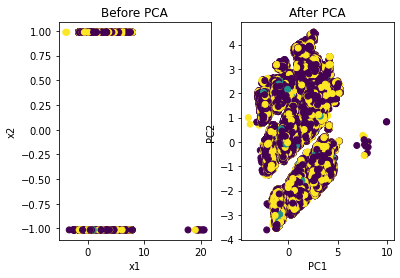

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = df_flights2[['crs_elapsed_time', 'year', 'month', 'day', 'week',
       'crs_dep_hour', 'crs_arr_hour', 'flight_haul_long',
       'flight_haul_medium', 'flight_haul_short', 'crs_arr_evening',
       'crs_arr_morning', 'crs_arr_night', 'crs_arr_noon', 'flight_type_ferry',
       'flight_type_mainline', 'flight_type_regional']]
y = df_flights2['is_delay']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], X[:,1], c=y)
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_title('Before PCA')

ax[1].scatter(components[:,0], components[:,1], c=y)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('After PCA')
plt.show()

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

### Looking for including or excluding features. It can help us to make the most accurate predictions

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [6]:
training_df = pd.read_csv('/content/drive/MyDrive/Feat_engineered_training_data_new.csv')

In [7]:
training_df.head()

,mkt_carrier_fl_num,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,week,mean_weekly_dest_delay,mean_weekly_origin_delay,arriving_flights_per_week,leaving_flights_per_week,flight_type_0,flight_type_ferry,flight_type_mainline,flight_type_regional,flight_haul_long,flight_haul_medium,flight_haul_short,crs_dep_hour,crs_arr_hour,month,day,carrier_AA,carrier_AS,carrier_B6,carrier_DL,carrier_F9,carrier_G4,carrier_HA,carrier_NK,carrier_UA,carrier_VX,carrier_WN
0,4917,-6.0,0.0,0.0,0.0,0.0,0.0,42,-3.669272,1.080318,6398,3399,0,0,0,1,0,0,1,13,14,10,17,0,0,0,1,0,0,0,0,0,0,0
1,681,-5.0,0.0,0.0,0.0,0.0,0.0,4,-3.190229,-0.628954,5977,6355,0,0,1,0,0,0,1,18,19,1,27,0,0,0,0,0,0,0,0,1,0,0
2,1075,29.0,0.0,0.0,29.0,0.0,0.0,33,1.425821,33.765468,1766,5868,0,0,1,0,1,0,0,18,21,8,16,0,0,0,0,0,0,0,0,1,0,0
3,826,9.0,0.0,0.0,0.0,0.0,0.0,39,-2.012551,-1.997789,2709,9498,0,0,1,0,0,0,1,9,11,9,23,0,0,0,0,0,0,0,0,0,0,1
4,2273,-13.0,0.0,0.0,0.0,0.0,0.0,3,11.181481,-0.681825,270,6377,0,0,1,0,0,0,1,13,14,1,15,0,1,0,0,0,0,0,0,0,0,0


In [8]:
training_df['mkt_carrier_delay'] = training_df.groupby(['mkt_carrier_fl_num'])['arr_delay'].transform(np.mean)

In [ ]:
#training_no_outliers = feat_engineered_training_data[(feat_engineered_training_data['arr_delay'] < 250)&(feat_engineered_training_data['arr_delay'] > -60)]

In [9]:
training_df_clear = training_df.drop(['carrier_delay',	'weather_delay',	'nas_delay',	'security_delay',	'late_aircraft_delay'], axis = 1).head(600000)

In [10]:
training_df_clear

,mkt_carrier_fl_num,arr_delay,week,mean_weekly_dest_delay,mean_weekly_origin_delay,arriving_flights_per_week,leaving_flights_per_week,flight_type_0,flight_type_ferry,flight_type_mainline,flight_type_regional,flight_haul_long,flight_haul_medium,flight_haul_short,crs_dep_hour,crs_arr_hour,month,day,carrier_AA,carrier_AS,carrier_B6,carrier_DL,carrier_F9,carrier_G4,carrier_HA,carrier_NK,carrier_UA,carrier_VX,carrier_WN,mkt_carrier_delay
0,4917,-6.0,42,-3.669272,1.080318,6398,3399,0,0,0,1,0,0,1,13,14,10,17,0,0,0,1,0,0,0,0,0,0,0,13.862197
1,681,-5.0,4,-3.190229,-0.628954,5977,6355,0,0,1,0,0,0,1,18,19,1,27,0,0,0,0,0,0,0,0,1,0,0,5.332055
2,1075,29.0,33,1.425821,33.765468,1766,5868,0,0,1,0,1,0,0,18,21,8,16,0,0,0,0,0,0,0,0,1,0,0,3.485995
3,826,9.0,39,-2.012551,-1.997789,2709,9498,0,0,1,0,0,0,1,9,11,9,23,0,0,0,0,0,0,0,0,0,0,1,1.560806
4,2273,-13.0,3,11.181481,-0.681825,270,6377,0,0,1,0,0,0,1,13,14,1,15,0,1,0,0,0,0,0,0,0,0,0,2.019950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,1025,-15.0,48,21.667741,11.332707,13968,1064,0,0,1,0,0,1,0,13,15,12,1,1,0,0,0,0,0,0,0,0,0,0,1.285959
599996,746,-8.0,16,15.723199,4.811177,1138,15126,0,0,1,0,0,0,1,13,14,4,15,0,0,0,1,0,0,0,0,0,0,0,-0.645299
599997,1640,-6.0,48,1.871514,16.083276,3012,5860,0,0,1,0,0,1,0,17,20,11,27,0,0,0,0,0,0,0,0,1,0,0,2.848889
599998,2242,-7.0,52,10.364315,11.332473,10318,6590,0,0,1,0,0,1,0,16,19,12,29,0,0,0,0,0,0,0,0,1,0,0,5.046489


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### Random Forest Regression

In [ ]:
from sklearn.model_selection import train_test_split
X = training_df.drop(['arr_delay'],axis=1)
y = training_df['arr_delay']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
clf.fit(X_train,y_train)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

Result with all delays

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.9235738763903485


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

90.39871808472118

### Using pickle to save model results

In [ ]:
import pickle
filename = 'random_forest.pickle'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_pred)
print(result)

## Feature Selection and new attempt in Modeling 

In [11]:
from sklearn.model_selection import train_test_split
X = training_df_clear.drop(['arr_delay'],axis=1)
y = training_df_clear['arr_delay']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=110, max_depth=20, random_state = 5000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

In [15]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

1144.324349519348


## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = training_df_clear.drop(['arr_delay'],axis=1)
y = training_df_clear['arr_delay']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)


In [ ]:
y_pred = clf_xgb.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

### Looking for the best parameters of Random Forest Regressor with GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
max_depth = [5, 8, 15, 25, 30, 45, 50]
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 100]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

gridF = GridSearchCV(clf, hyperF, cv = 5)#, verbose = 3, n_jobs = -1)

In [ ]:
gridcv = gridF.fit(X_train,y_train)

In [ ]:
gridcv.best_params_

In [ ]:
rfc = RandomForestClassifier(n_estimators = , max_depth = )
rfc.fit(X_train,y_train)
y_pred1 = rfc.predict(X_test)

In [ ]:
print(r2_score(y_test, y_pred1))

### ***Logistic Regression is not working!***

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

print(r2_score(y_test, y_pred))

### Looking for the most correlated variables to drop

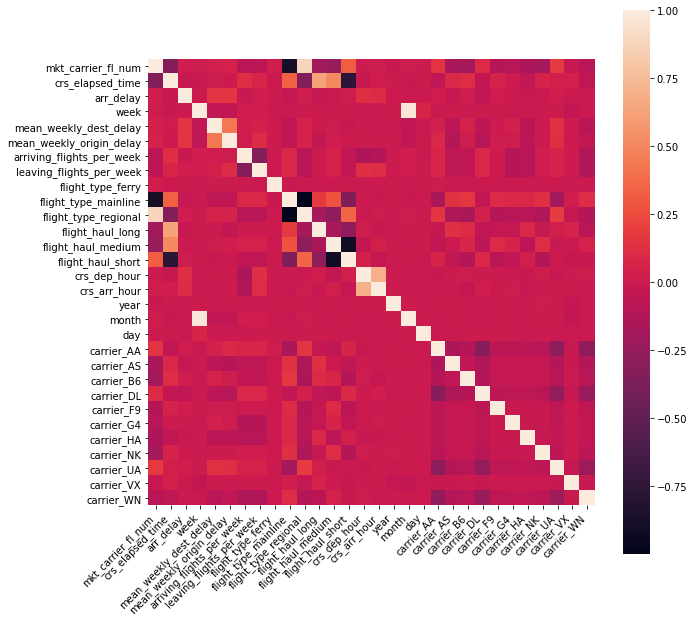

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))  
df_corr = training_no_outliers.corr()
ax = sns.heatmap(
    df_corr, 
    #cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


gnb = GaussianNB()

X = training_no_outliers.drop(['arr_delay','mkt_carrier_fl_num','crs_elapsed_time'],axis=1)
y = training_no_outliers['arr_delay']

#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

-0.9278251983674091


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.0003580465943332086

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.